# Statistical Analysis

[This notebook](https://github.com/dattalab/keypoint-moseq/blob/main/docs/source/analysis.ipynb) contains routines for analyzing the output of keypoint-MoSeq.

```{note}
The interactive widgets require jupyterlab launched from the `keypoint_moseq` environment. They will not work properly in jupyter notebook.
```


## Setup

We assume you have already have keypoint-MoSeq outputs that are organized as follows.
```
<project_dir>/               ** current working directory
└── <model_name>/            ** model directory
    ├── results.h5           ** model results
    └── grid_movies/         ** [Optional] grid movies folder
```
Use the code below to enter in your project directory and model name.

In [ ]:
%matplotlib widget
import keypoint_moseq as kpms

project_dir = "path/to/project"  # the full path to the project directory
video_dir = "path/to/videos"
model_name = "model_name"  # name of model to analyze (e.g. something like `2023_05_23-15_19_03`)

kpms.initialize_analysis_notebook(project_dir)

## Assign Groups

The goal of this step is to assign group labels (such as "mutant" or "wildtype") to each recording. These labels are important later for performing group-wise comparisons.
- The widget below allows you to edit the 'group' column of {project_dir}/recordings.csv
    - On running the cell, you will see 'Dash app running on {link}'. Click the link to open the widget.
    - Click cells in the "group" column and enter new group labels.
    - Hit `Save Group Assignments` when you're done.

In [ ]:
kpms.set_group_labels()

##  Label syllables

The goal of this step is name each syllable (e.g., "rear up" or "walk slowly").
- On running the cell, you will see 'Dash app running on {link}'. Click the link to open the widget.
- Select syllables from the dropdown to see their grid movies
- Use the movies to label the syllables in the table

In [ ]:
kpms.label_syllables(model_name)

Row
    [0] Column
        [0] Select(options=[0, 1, 2, 3, 4, ...], value=0)
        [1] ParamFunction(function, _pane=Video, defer_load=False)
    [1] Column
        [0] Tabulator(editors={'name': None, ...}, show_index=False, titles={'syllable': 'syllable', ...}, value=    syllable l..., widths={'syllable': 100})
        [1] Column
            [0] Button(button_type='primary', name='Save syllable info')

## Compare between groups
Check for syllable usage differences between groups. If a difference is significant, it will be represented by an asterisk.

Saved figure to ../../testing/demo_project/2023_08_01-10_16_25/figures/frequency_stat_stats.png


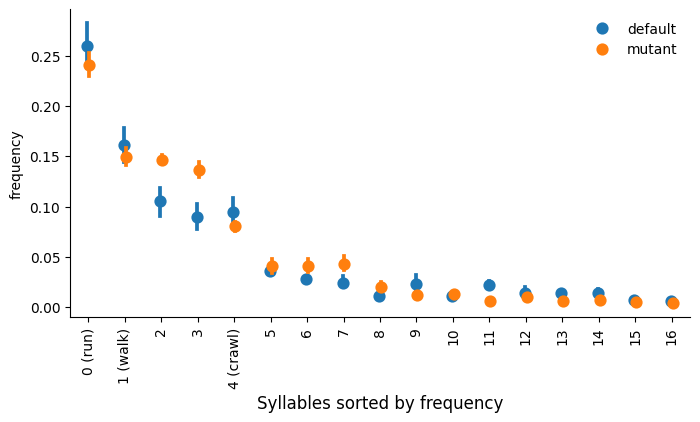

In [ ]:
kpms.plot_syllable_usage(model_name)

### Transition matrices
Generate heatmaps showing the transition frequencies between syllables.

Group(s): default, mutant
Saved figure to ../../testing/demo_project/2023_08_01-10_16_25/figures/transition_matrices.png


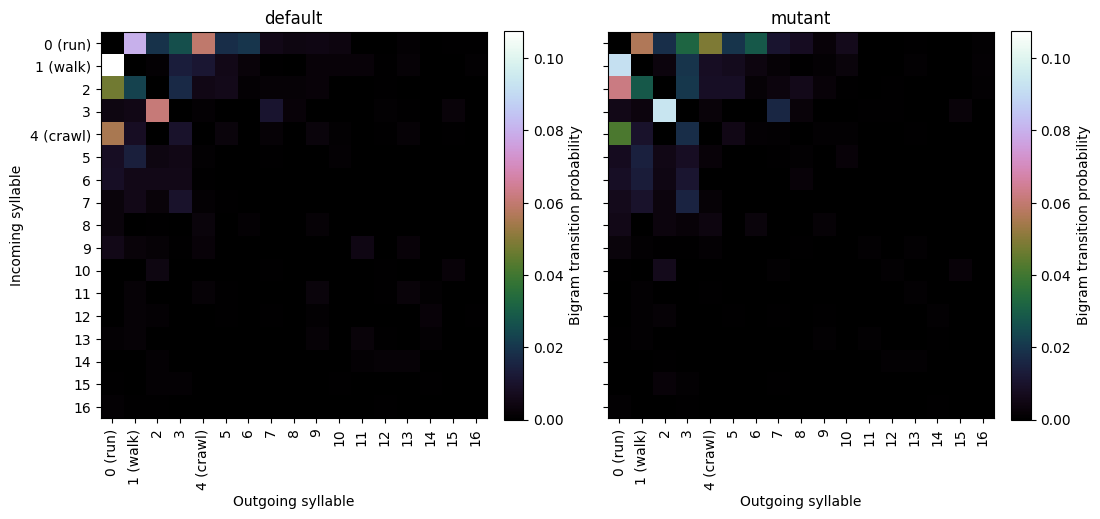

In [7]:
normalize = "bigram"  # normalization method ("bigram", "rows" or "columns")

trans_mats, usages, groups, syll_include = kpms.generate_transition_matrices(
    project_dir,
    model_name,
    normalize=normalize,
    min_frequency=0.005,  # minimum syllable frequency to include
)

kpms.visualize_transition_bigram(
    project_dir,
    model_name,
    groups,
    trans_mats,
    syll_include,
    normalize=normalize,
    show_syllable_names=True,  # label syllables by index (False) or index and name (True)
)

### Syllable Transition Graph
Render transition rates in graph form, where nodes represent syllables and edges represent transitions between syllables, with edge width showing transition rate for each pair of syllables (secifically the max of the two transition rates in each direction).

Saved figure to ../../testing/demo_project/2023_08_01-10_16_25/figures/transition_graphs.png


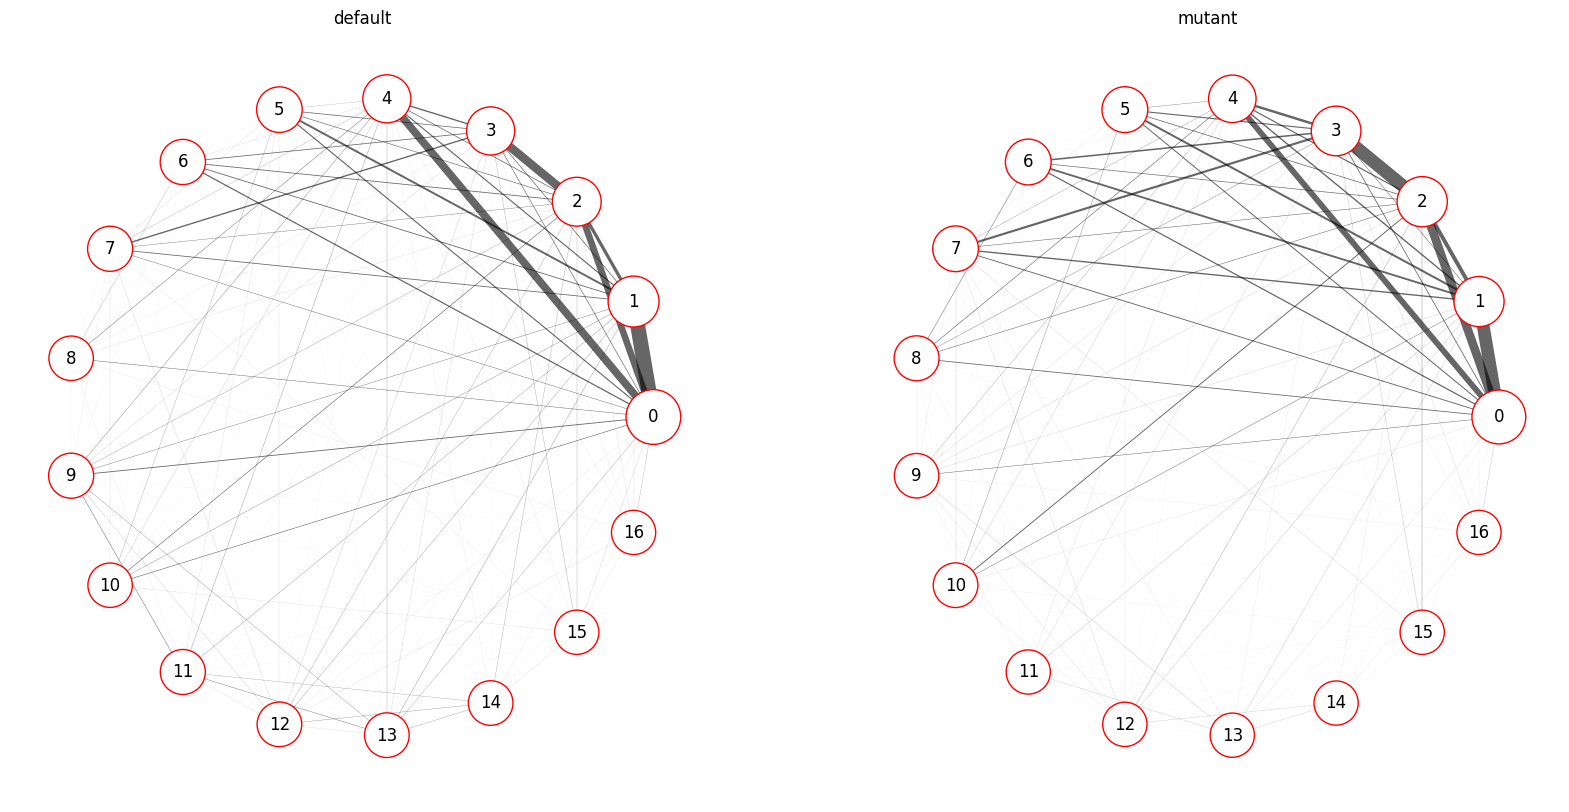

In [8]:
# Generate a transition graph for each single group

kpms.plot_transition_graph_group(
    project_dir,
    model_name,
    groups,
    trans_mats,
    usages,
    syll_include,
    layout="circular",  # transition graph layout ("circular" or "spring")
    show_syllable_names=False,  # label syllables by index (False) or index and name (True)
)

Saved figure to ../../testing/demo_project/2023_08_01-10_16_25/figures/transition_graphs_diff.png


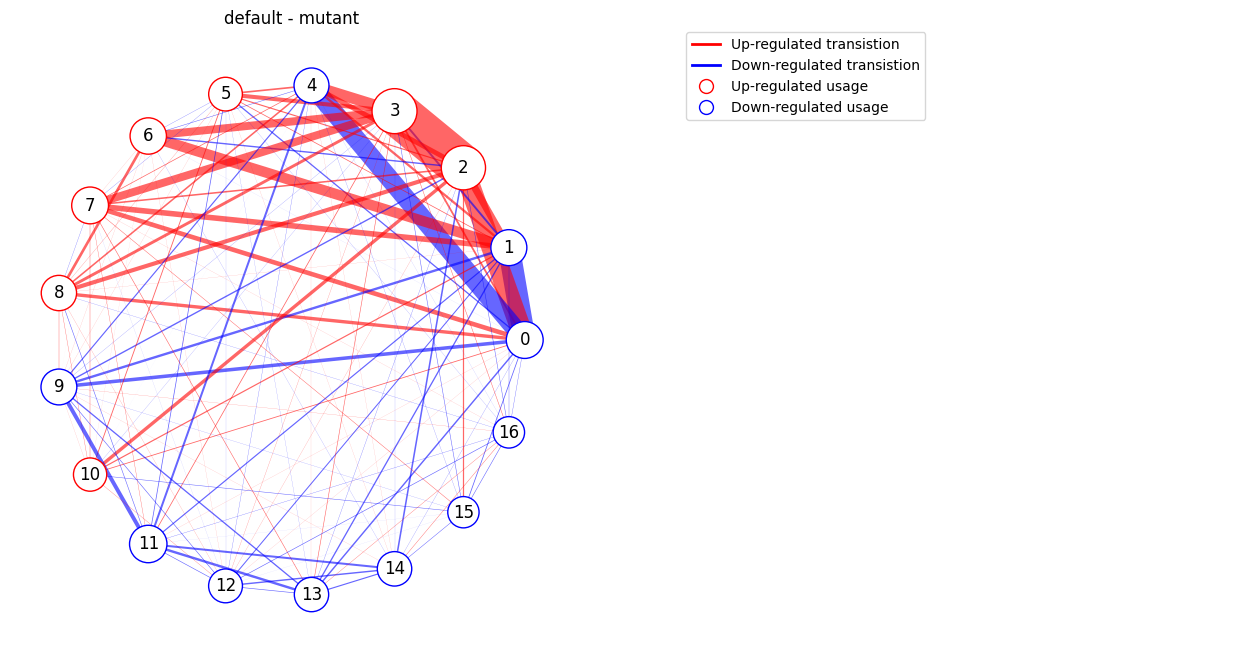

In [9]:
# Generate a difference-graph for each pair of groups.

kpms.plot_transition_graph_difference(
    project_dir, model_name, groups, trans_mats, usages, syll_include, layout="circular"
)  # transition graph layout ("circular" or "spring")